# **Linear Regression & Regularizations**

In [2]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [3]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

**Data preparation**

In [4]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))
cycling_data["DATUM_A_CAS"] = pd.to_datetime(cycling_data["DATUM_A_CAS"], errors="coerce")
cycling_data["DATUM_A_CAS"] = cycling_data["DATUM_A_CAS"].dt.date

In [5]:
cycling_data = cycling_data[["NAZOV", "SMER_DO", "SMER_Z", "DATUM_A_CAS", "POCET_DO", "POCET_Z"]]

aggregated_data = cycling_data.groupby(["NAZOV", "DATUM_A_CAS"], as_index=False).sum(numeric_only=True)
aggregated_data = aggregated_data[aggregated_data["DATUM_A_CAS"] >= datetime.date(2022, 1, 1)]

aggregated_data["POCET"] = aggregated_data["POCET_DO"] + aggregated_data["POCET_Z"]
aggregated_data = aggregated_data[["NAZOV", "DATUM_A_CAS", "POCET"]]

In [6]:
# Weather data
weather_data = pd.read_csv(download_link("https://drive.google.com/file/d/1keTewFIu3ceNYhfNuiLxD9vqlcW5t2S9/view?usp=sharing")).fillna(0)

# Average temperature, Min temperature, Max temperature, Precipitation, Snowing (rarely), Wind speed, Pressure
weather_data = weather_data[["date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]]
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data["date"] = weather_data["date"].dt.date

**Train-Val-Test split**

We have decided to use year wise split of data, avoiding COVID-19 quarantine years before 2022. We perform split based on percentages, because not all data have the same length. In order to take into account data chronology, we use first <code>60 %</code> of data for training, second <code>30 %</code> for validation and remaining <code>10 %</code> for testing purposes.

In [7]:
# Getting all the routes available
routes_data = list(aggregated_data["NAZOV"].unique())

In [8]:
# Trying Starý most
x = ["tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]
y = ["POCET_DO", "POCET_Z"]

# Linear regression

In [9]:
mae_lr = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = LinearRegression()

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = scaler_X.transform(VALIDATION[x])

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_lr[route_name] = 100*mae/np.mean(DATA["POCET"])


# LASSO

In [10]:
coefficients_lasso = {'#1 - Starý Most': np.float64(1.99),
 '#10 - Dunajská': np.float64(0.29),
 '#11 - Most Apollo': np.float64(0.01),
 '#12 - Železná studnička': np.float64(1.99),
 '#13 - Vajanského 1': np.float64(0.51),
 '#14 - Vajanského 2': np.float64(1.99),
 '#15 - Incheba Einsteinova': np.float64(0.12),
 '#16 - Trenčianska': np.float64(1.99),
 '#17 - Dunajská/Lazaretská': np.float64(0.01),
 '#2 - Starý most 2': np.float64(0.42),
 '#3 - River Park': np.float64(0.01),
 '#4 - Dolnozemská': np.float64(0.01),
 '#5 - Devínska cesta': np.float64(1.99),
 '#6 - Vajnorská': np.float64(0.01),
 '#7 - Vajnorská > NTC': np.float64(1.99),
 '#8 - Most SNP': np.float64(0.01),
 '#9 - Páričkova': np.float64(0.01),
 'Cyklomost Slobody': np.float64(1.99),
 'Devinska Nova Ves': np.float64(0.01),
 'Hradza Berg': np.float64(0.01),
 'Viedenska': np.float64(0.01)}

In [11]:
mae_lasso = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = Lasso(alpha=coefficients_lasso[route], max_iter=1500)

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = scaler_X.transform(VALIDATION[x])

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_lasso[route_name] = 100*mae/np.mean(VALIDATION["POCET"])

# RIDGE

In [12]:
coefficients_ridge = {'#1 - Starý Most': np.float64(9.99),
 '#10 - Dunajská': np.float64(7.12),
 '#11 - Most Apollo': np.float64(0.01),
 '#12 - Železná studnička': np.float64(9.99),
 '#13 - Vajanského 1': np.float64(9.99),
 '#14 - Vajanského 2': np.float64(9.99),
 '#15 - Incheba Einsteinova': np.float64(1.11),
 '#16 - Trenčianska': np.float64(9.99),
 '#17 - Dunajská/Lazaretská': np.float64(0.01),
 '#2 - Starý most 2': np.float64(9.99),
 '#3 - River Park': np.float64(0.01),
 '#4 - Dolnozemská': np.float64(0.01),
 '#5 - Devínska cesta': np.float64(9.99),
 '#6 - Vajnorská': np.float64(0.01),
 '#7 - Vajnorská > NTC': np.float64(9.99),
 '#8 - Most SNP': np.float64(0.01),
 '#9 - Páričkova': np.float64(0.01),
 'Cyklomost Slobody': np.float64(9.99),
 'Devinska Nova Ves': np.float64(0.01),
 'Hradza Berg': np.float64(0.01),
 'Viedenska': np.float64(0.01)}

In [13]:
mae_ridge = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = Ridge(alpha=coefficients_ridge[route])

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = scaler_X.transform(VALIDATION[x])

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_ridge[route_name] = 100*mae/np.mean(VALIDATION["POCET"])

# Visuals of deviations

In [14]:
mae_lr = dict(sorted(mae_lr.items(), key=lambda x: x[1], reverse=True))
mae_lasso = dict(sorted(mae_lasso.items(), key=lambda x: x[1], reverse=True))
mae_ridge = dict(sorted(mae_ridge.items(), key=lambda x: x[1], reverse=True))

In [15]:
print("LR", np.mean(list(mae_lr.values())))
print("LASSO", np.mean(list(mae_lasso.values())))
print("RIDGE", np.mean(list(mae_ridge.values())))

LR 48.73563247676895
LASSO 54.41996138344008
RIDGE 54.375133144383135


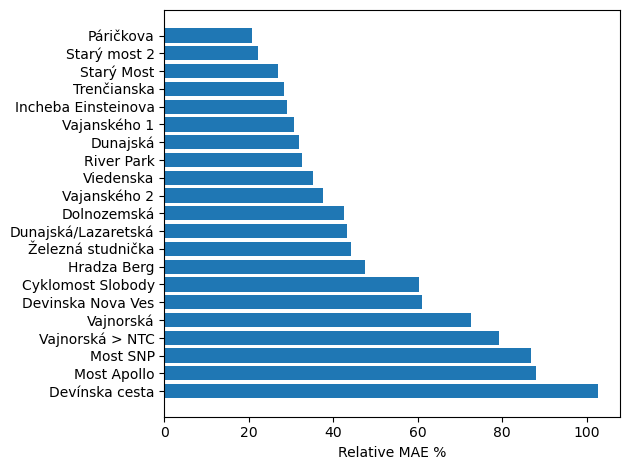

In [16]:
# Assume mae_lr, mae_ridge, mae_lasso are dicts
routes = list(mae_lr.keys())  # use one dict as reference

# Extract values in the same order as routes
lr_values = [mae_lr[r] for r in routes]
ridge_values = [mae_ridge[r] for r in routes]
lasso_values = [mae_lasso[r] for r in routes]

y = np.arange(len(routes))
height = 0.25

# Plot grouped bars
#plt.barh(y - height, lr_values, height=height, label='Linear Regression')
plt.barh(y, lr_values, label='RIDGE')
#plt.barh(y + height, lasso_values, height=height, label='LASSO')

plt.yticks(y, routes)
plt.xlabel("Relative MAE %")
#plt.legend()
plt.tight_layout()
plt.show()


# Testing

In [17]:
mae_lr_TEST = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = LinearRegression()

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = scaler_X.transform(TEST[x])

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(TEST["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_lr_TEST[route_name] = 100*mae/np.mean(TEST["POCET"])


In [18]:
mae_lasso_TEST = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = Lasso(alpha=coefficients_lasso[route], max_iter=1500)

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_test = scaler_X.transform(TEST[x])

    # Predict
    y_pred = MODEL.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(TEST["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_lasso_TEST[route_name] = 100*mae/np.mean(TEST["POCET"])

In [ ]:
mae_ridge_TEST = {}
for route in routes_data:
    route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

    DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = Ridge(alpha=coefficients_ridge[route], max_iter=1500)

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[x])
    y_train = TRAIN[["POCET"]]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_test = scaler_X.transform(TEST[x])

    # Predict
    y_pred = MODEL.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(TEST["POCET"], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_ridge_TEST[route_name] = 100*mae/np.mean(TEST["POCET"])

In [20]:
mae_lr_TEST = dict(sorted(mae_lr_TEST.items(), key=lambda x: x[1], reverse=True))
mae_lasso_TEST = dict(sorted(mae_lasso_TEST.items(), key=lambda x: x[1], reverse=True))
mae_ridge_TESR = dict(sorted(mae_ridge_TEST.items(), key=lambda x: x[1], reverse=True))

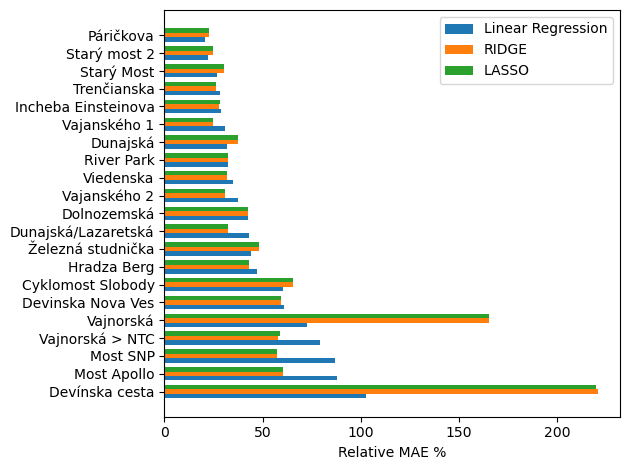

In [22]:
# Assume mae_lr, mae_ridge, mae_lasso are dicts
routes = list(mae_lr.keys())  # use one dict as reference

# Extract values in the same order as routes
lr_values = [mae_lr[r] for r in routes]
ridge_values = [mae_ridge[r] for r in routes]
lasso_values = [mae_lasso[r] for r in routes]

y = np.arange(len(routes))
height = 0.25

# Plot grouped bars
plt.barh(y - height, lr_values, height=height, label='Linear Regression')
plt.barh(y, ridge_values, height=height, label='RIDGE')
plt.barh(y + height, lasso_values, height=height, label='LASSO')

plt.yticks(y, routes)
plt.xlabel("Relative MAE %")
plt.legend()
plt.tight_layout()
plt.show()
